In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import os

from typing import List, Tuple, Any

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from scipy import stats

%matplotlib inline

### I. Overview & Creating the dataset

This dataset comes from http://capitalbikeshare.com - A popular choice for tourists or anyone wanting to explore the DC area at their own pace.

*Source: https://s3.amazonaws.com/capitalbikeshare-data/index.html

- 

In [2]:
dataset = pd.DataFrame()
data_dir = '../data'
for file in os.listdir(data_dir):
    tmp = pd.read_csv(os.path.join(data_dir, file))
    dataset = pd.concat([dataset, tmp], sort=False, ignore_index=True)

print(f'Complete Dataset (rows, columns): {dataset.shape}')
testset = dataset.sample(frac=0.33, random_state=33)
dataset.drop(testset.index, inplace=True)
print(f'Trainset (rows, columns): {dataset.shape}')
print(f'Testset (rows, columns): {testset.shape}')
dataset.head()

Complete Dataset (rows, columns): (1104418, 9)
Trainset (rows, columns): (739960, 9)
Testset (rows, columns): (364458, 9)


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
1,590,2017-04-01 00:02:02,2017-04-01 00:11:53,31109,7th & T St NW,31278,18th & R St NW,W20006,Member
2,2938,2017-04-01 00:02:32,2017-04-01 00:51:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31238,14th & G St NW,W22225,Casual
3,380,2017-04-01 00:03:02,2017-04-01 00:09:23,31121,Calvert St & Woodley Pl NW,31104,Adams Mill & Columbia Rd NW,W20146,Member
4,423,2017-04-01 00:03:38,2017-04-01 00:10:41,31023,Fairfax Dr & Wilson Blvd,31034,N Randolph St & Fairfax Dr,W00316,Member
5,1422,2017-04-01 00:04:12,2017-04-01 00:27:55,31077,Iwo Jima Memorial/N Meade & 14th St N,31036,George Mason Dr & Wilson Blvd,W20489,Member


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739960 entries, 1 to 1104416
Data columns (total 9 columns):
Duration                739960 non-null int64
Start date              739960 non-null object
End date                739960 non-null object
Start station number    739960 non-null int64
Start station           739960 non-null object
End station number      739960 non-null int64
End station             739960 non-null object
Bike number             739960 non-null object
Member type             739960 non-null object
dtypes: int64(3), object(6)
memory usage: 56.5+ MB


### II. Exploratory Data Analysis

- Here are a few interesting takeways from the dataset

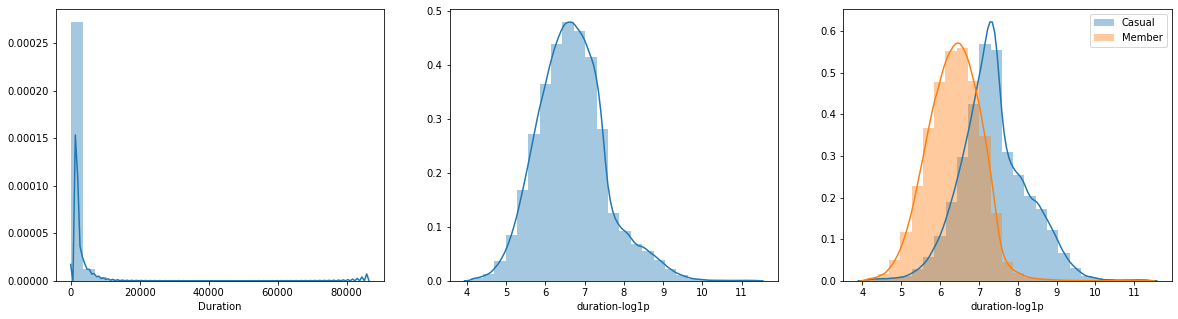

In [4]:
# starting with the target feature: "Duration"
plt.figure(figsize=(20,5));

plt.subplot(1,3,1);
sns.distplot(dataset['Duration'], bins=25);

plt.subplot(1,3,2);
dataset['duration-log1p'] = np.log1p(dataset['Duration'])
sns.distplot(dataset['duration-log1p'], bins=25);

plt.subplot(1,3,3);
sns.distplot(dataset.loc[dataset['Member type'] == 'Casual', 'duration-log1p'], bins=25, label='Casual');
sns.distplot(dataset.loc[dataset['Member type'] == 'Member', 'duration-log1p'], bins=25, label='Member');
plt.legend();

In [5]:
# "Duration" and "Start dates"
# ("End date" also exists in this dataset, but given the problem I've decided to solve it will be ignored.)
dataset['start-date-ts'] = pd.to_datetime(dataset['Start date'])
dataset['day-of-week'] = dataset['start-date-ts'].apply(lambda x: x.dayofweek)
dataset['month'] = dataset['start-date-ts'].apply(lambda x: x.month)
dataset['minute'] = dataset['start-date-ts'].apply(lambda x: x.minute)
dataset['hour'] = dataset['start-date-ts'].apply(lambda x: x.hour)

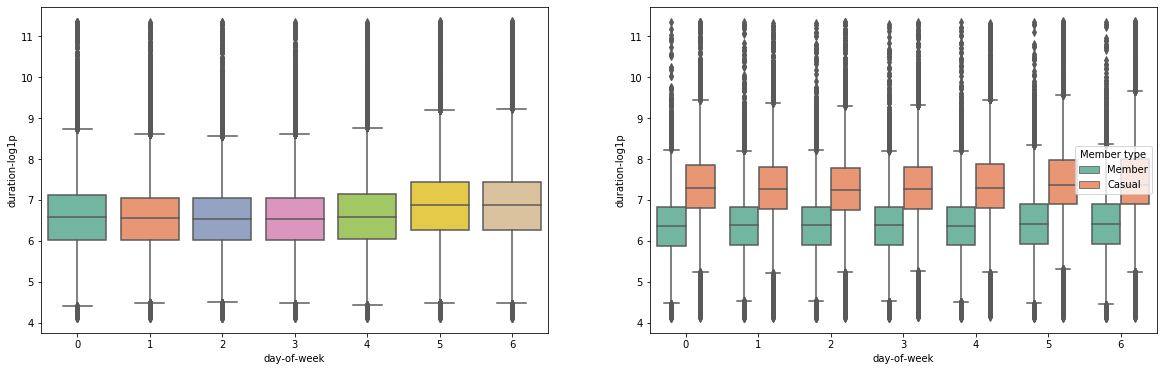

In [6]:
plt.figure(figsize=(20,6));

plt.subplot(1,2,1);
sns.boxplot(x='day-of-week', y='duration-log1p', data=dataset, palette='Set2');

plt.subplot(1,2,2);
sns.boxplot(x='day-of-week', y='duration-log1p', hue='Member type', data=dataset, palette='Set2');

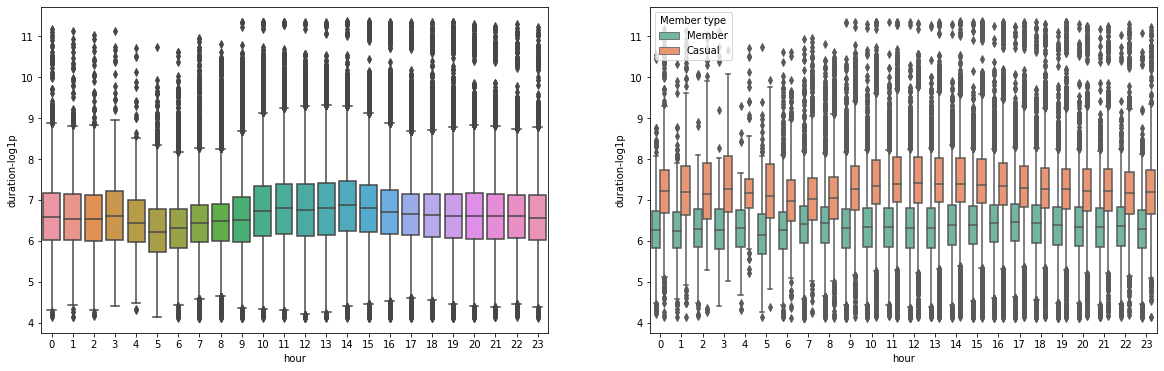

In [7]:
plt.figure(figsize=(20,6));

plt.subplot(1,2,1);
sns.boxplot(x='hour', y='duration-log1p', data=dataset);

plt.subplot(1,2,2);
sns.boxplot(x='hour', y='duration-log1p', hue='Member type', data=dataset, palette='Set2');

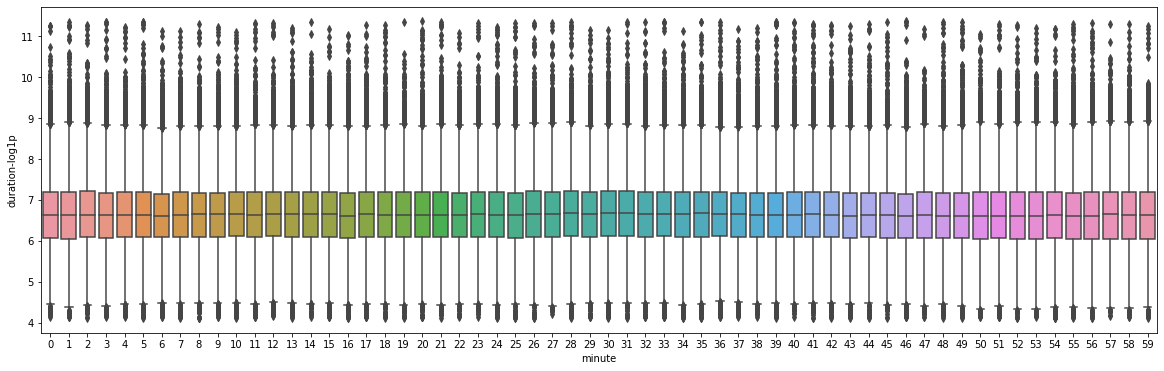

In [8]:
plt.figure(figsize=(20,6));

sns.boxplot(x='minute', y='duration-log1p', data=dataset);

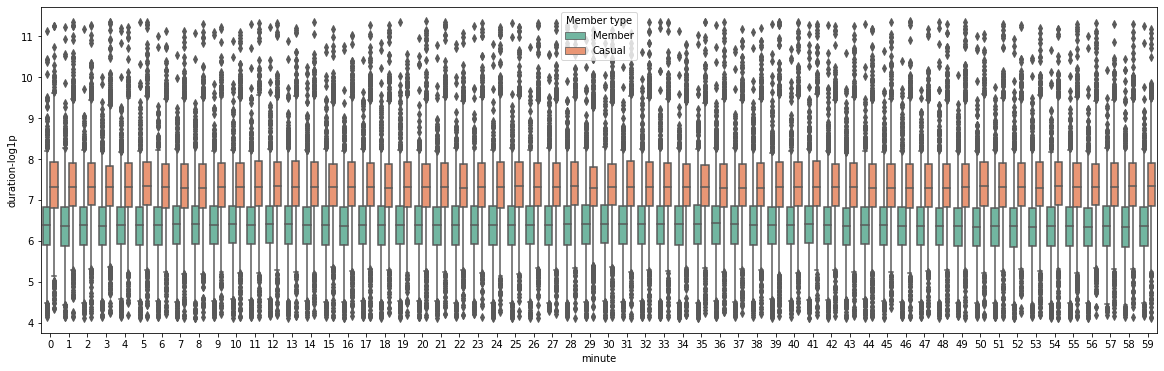

In [9]:
plt.figure(figsize=(20,6));

sns.boxplot(x='minute', y='duration-log1p', hue='Member type', data=dataset, palette='Set2');

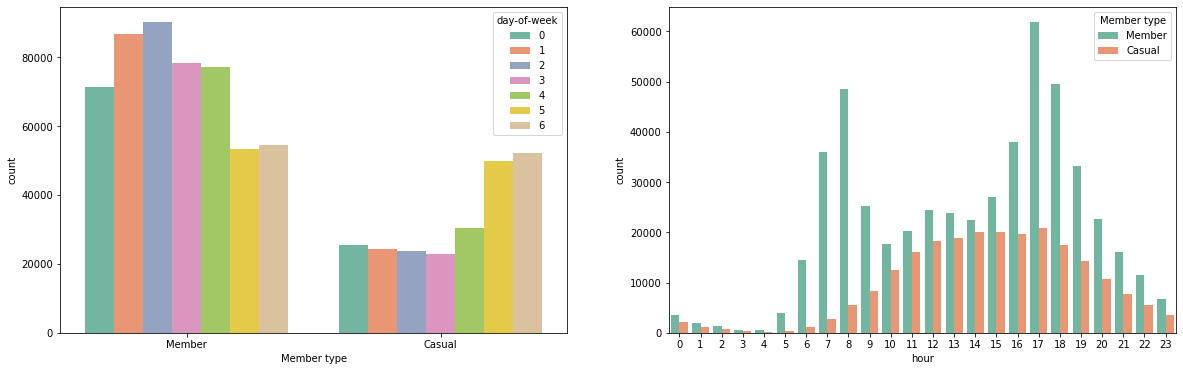

In [10]:
plt.figure(figsize=(20,6));

plt.subplot(1,2,1);
sns.countplot(x='Member type', hue='day-of-week', data=dataset, palette='Set2');

plt.subplot(1,2,2);
sns.countplot(x='hour', hue='Member type', data=dataset, palette='Set2');

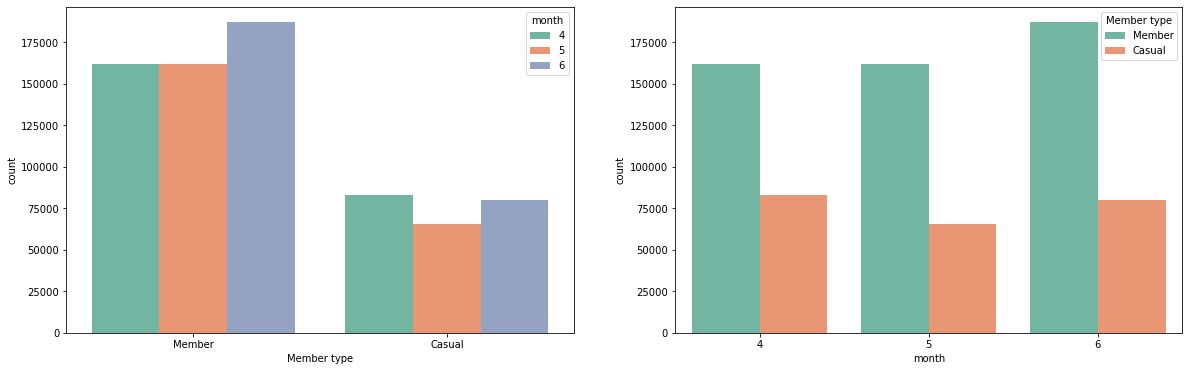

In [11]:
plt.figure(figsize=(20,6));

plt.subplot(1,2,1);
sns.countplot(x='Member type', hue='month', data=dataset, palette='Set2');

plt.subplot(1,2,2);
sns.countplot(x='month', hue='Member type', data=dataset, palette='Set2');

### III. Creating the Prediction Pipeline

In [12]:
class PrepareRiders(BaseEstimator, TransformerMixin):
    
    def __init__(self, use_columns: list, station_median_dict: dict):
        self.use_columns = use_columns
        self.station_median_dict = station_median_dict
        self._final_columns = None
        
    def _station_median_duration(self, station_num: int) -> float:
        return self.station_median_dict.get(station_num, 0)
        
    def transform(self, Xt: pd.DataFrame) -> np.array:
        # only use specified columns
        Xt = Xt.loc[:, self.use_columns]
        print(f'Initial dataset shape: {Xt.shape}')
        
        # convert to date types
        Xt['start-date-ts'] = pd.to_datetime(Xt['Start date'])
        
        # separate out date features
        Xt['day-of-week'] = Xt['start-date-ts'].apply(lambda x: x.dayofweek)
        Xt['month'] = Xt['start-date-ts'].apply(lambda x: x.month)
        Xt['minute'] = Xt['start-date-ts'].apply(lambda x: x.minute)
        Xt['hour'] = Xt['start-date-ts'].apply(lambda x: x.hour)
        Xt.drop(['Start date', 'start-date-ts'], axis=1, inplace=True)
        
        # convert to categoricals via pd.cut
        day_bins = range(0,7)
        Xt['day-of-week'] = pd.cut(Xt['day-of-week'], bins=day_bins, right=False)
        month_bins = range(1,13)
        Xt['month'] = pd.cut(Xt['month'], bins=month_bins, right=False)
        minute_bins = range(0, 70, 10)
        Xt['minute'] = pd.cut(Xt['minute'], bins=minute_bins, right=False)
        hour_bins = range(0, 24)
        Xt['hour'] = pd.cut(Xt['hour'], bins=hour_bins, right=False)
        
        # custom transformation
        Xt['station-median'] = Xt['Start station number'].apply(lambda x: self._station_median_duration(x))
        
        # transform categorical features
        Xt['start-station-num'] = Xt['Start station number'].astype(str)
        Xt.drop(['Start station number'], axis=1, inplace=True)
        Xt = pd.get_dummies(Xt)
        
        # save final columns
        if not self._final_columns:
            self._final_columns = Xt.columns.tolist()
        else:
            not_in_training = list(set(Xt.columns.tolist()) - set(self._final_columns))
            not_in_testing = list(set(self._final_columns) - set(Xt.columns.tolist()))
            if not_in_training:
                Xt.drop(not_in_training, axis=1, inplace=True)
            if not_in_testing:
                empties = dict.fromkeys(not_in_testing, 0)
                Xt = Xt.assign(**empties)
        print(f'Prepared dataset shape: {Xt.shape}')
        return Xt.values
    
    def fit(self, X, y=None, **kwargs):
        return self


In [13]:
def rmse_func(y_true: np.array, y_pred: np.array) -> float:
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

In [14]:
def scoresReport(y_true: np.array, y_pred: np.array) -> None:
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = rmse_func(y_true, y_pred)
    print(f'Scores Report:\nR2: {r2}\nMSE: {mse}\nRMSE: {rmse}\n')
    return

# plot the residuals
def fourPlot(y_true: np.array, y_pred: np.array) -> None:
    plt.figure(figsize=(12,8));
    residuals = y_true - y_pred
    # Histogram
    plt.subplot(2,2,1);
    plt.title("Histogram");
    plt.hist(residuals, alpha=0.5);
    # Lag plot
    plt.subplot(2,2,2);
    plt.title("Lag Plot");
    lag = residuals.copy()
    lag = lag[:-1]
    current = residuals[1:]
    sns.regplot(current, lag, fit_reg=False);
    # QQ plot
    plt.subplot(2,2,3);
    plt.title("QQ Plot");
    qntls, xr = stats.probplot(residuals, fit=False)
    sns.regplot(xr, qntls, ci=0);
    # Run Sequence plot
    plt.subplot(2,2,4);
    plt.title("Run Sequence");
    sns.regplot(np.arange(len(residuals)), residuals, ci=0);
    return

In [15]:
def run_gridsearch_with_pipe(
        regressors: list, params_map: dict, cv: KFold,
        x1: pd.DataFrame, x2: pd.DataFrame, y1: np.array, y2: np.array) -> None:
        
    for reg, model in regressors:
        params = params_map[reg]
        pipe = Pipeline(
            steps=[
                ('prepare', PrepareRiders(use_columns=use_columns, station_median_dict=station_medians)),
                (reg, model(random_state=33))
            ]
        )
        grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=rmse_scorer, cv=kf, n_jobs=2)
        grid.fit(x1, y1)
        best_est = grid.best_estimator_.named_steps[reg]
        prep = grid.best_estimator_.named_steps['prepare']
        # top_features = pd.Series(est.feature_importances_, index=prep._final_columns).sort_values(ascending=False).head(10)
        test_preds = grid.predict(x2)
        testset_raw_score = np.sqrt(mean_squared_error(y2, test_preds))
        testset_rmse_expm1 = np.sqrt(mean_squared_error(np.expm1(y2), np.expm1(test_preds)))
        context_error = f'This model is off by ~{round(testset_rmse_expm1 / 60, 2)} minutes'
#         print(f'Model: {reg}\nRMSE: {testset_raw_score}\nRMSE EXPM1: {testset_rmse_expm1}\nCONTEXT: {context_error}\nPARAMS: {grid.best_params_}')
        # check residuals with the "Four Plot"
        scoresReport(y2, test_preds)
        print(f'Context error: {context_error}')
        fourPlot(y2, test_preds)
        

In [16]:
# create training and testing inputs and target features
x1, y1 = dataset.iloc[:,1:], dataset['duration-log1p'].values
x2, y2 = testset.iloc[:,1:], np.log1p(testset['Duration']).values

# create input parameters to PrepareRiders
use_columns = ['Start date', 'Member type', 'Start station number']
station_medians = dataset.groupby('Start station number').agg({'Duration': ['median']}).to_dict()[('Duration', 'median')]

In [18]:
params_map = {
    'rf': {
        'rf__max_depth': [5],
        'rf__n_estimators': [150],
    },
#     'gb': {
#         'gb__max_depth': [3, 5],
#         'gb__n_estimators': [100, 150],
#         'gb__learning_rate': [0.1],
#     },
#     'ls': {
#         'ls__alpha': [0.5],
#     },
}

regressors = [
    ('rf', RandomForestRegressor),
#     ('gb', GradientBoostingRegressor),
#     ('ls', Lasso),
]

kf = KFold(n_splits=3, shuffle=False, random_state=33)

run_gridsearch_with_pipe(
    regressors=regressors, 
    params_map=params_map,
    cv=kf,
    x1=x1,
    x2=x2,
    y1=y1,
    y2=y2
)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

### IV. Making Adjustments

In [16]:
# Checking for outliers
longest_ride_minutes = dataset['Duration'].max() / 60
longest_ride_hours = longest_ride_minutes / 60
print(f'The longest ride lasted for {longest_ride_minutes:.2f} minutes ({longest_ride_hours:.2f} hours)')

shortest_ride_minutes = dataset['Duration'].min() / 60
shortest_ride_hours = shortest_ride_minutes / 60
print(f'The shortest ride lasted for {shortest_ride_minutes:.2f} minutes ({shortest_ride_hours:.2f} hours)')

The longest ride lasted for 1428.42 minutes (23.81 hours)
The shortest ride lasted for 1.00 minutes (0.02 hours)


In [17]:
# What is a reasonable time for a bike ride with capitalbikeshare?
# There's no really wrong answer. This is a scenario where you would need to ask the SME (subject matter expert).
# Unfortunately, I don't work at capitalbikeshare, so I'll need to make a best guess (using the data!).

In [23]:
prev_b = 0
for b in np.arange(600, 43201, step=600):
    num_rides = dataset.loc[(dataset.Duration >= prev_b) & (dataset.Duration <= b)].shape[0]
    print(f'There are {num_rides} rides between {prev_b} and {b}')
    prev_b = b

There are 155302 rides between 0 and 600
There are 89205 rides between 600 and 1200
There are 25203 rides between 1200 and 1800
There are 5241 rides between 1800 and 2400
There are 2291 rides between 2400 and 3000
There are 1500 rides between 3000 and 3600
There are 1058 rides between 3600 and 4200
There are 835 rides between 4200 and 4800
There are 717 rides between 4800 and 5400
There are 599 rides between 5400 and 6000
There are 484 rides between 6000 and 6600
There are 364 rides between 6600 and 7200
There are 283 rides between 7200 and 7800
There are 229 rides between 7800 and 8400
There are 208 rides between 8400 and 9000
There are 99 rides between 9000 and 9600
There are 91 rides between 9600 and 10200
There are 64 rides between 10200 and 10800
There are 61 rides between 10800 and 11400
There are 49 rides between 11400 and 12000
There are 38 rides between 12000 and 12600
There are 28 rides between 12600 and 13200
There are 19 rides between 13200 and 13800
There are 19 rides betw

In [54]:
threeHoursAsSeconds = 60 * 60 * 3
dataset.loc[dataset.Duration > threeHoursAsSeconds].shape[0]

496

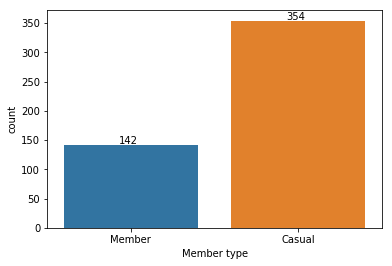

In [61]:
# Who's taking these long rides?
long_rides = dataset.loc[dataset.Duration > threeHoursAsSeconds]
ax = sns.countplot(x='Member type', data=long_rides);
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()+2));

# Casuals...

### IV. Model Performance

### V. Saving and exporting the Pipeline 

In [47]:
dill.dump(pipe, open('pipe.v1', 'wb'), recurse=True)